In [2]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
def get_stim_resp(pp,y):
    n_rois = y.shape[0]
    frame_times = np.array(pp.metadata['frame_times']).mean(axis=1)
    
    stim_times = [pp.metadata['mark_points']['initial_delay']]
    for i in range(pp.metadata['mark_points']['repetitions']-1):
        stim_times.append(pp.metadata['mark_points']['inter_point_delay']+pp.metadata['mark_points']['duration'])
    stim_times = np.array(stim_times)/1000
    stim_times = np.cumsum(stim_times)
    
    stim_inds = []
    for time in stim_times:
        stim_inds.append( np.argwhere((frame_times-time)>0)[0][0])
    stim_inds = np.array(stim_inds)
    
    for ind in stim_inds:
        y[ind-1:ind+1] = np.nan
    # y[stim_inds]=np.nan
    # y[stim_inds-1]=np.nan
    # y[stim_inds+1]=np.nan
    
    stim_resp = np.zeros((len(stim_inds)-1,  80))
    for i, ind in enumerate(stim_inds[1:]):
        stim_resp[i,:] = y[ind-10:ind+70]
    stim_resp /= np.nanmean(stim_resp[:,:10], axis=-1, keepdims=True)
    # stim_resp[:,:9] = sp.ndimage.gaussian_filter1d(stim_resp[:,:9],1,axis=-1)
    # stim_resp[:,12:] = sp.ndimage.gaussian_filter1d(stim_resp[:,12:],1,axis=-1)
    
    return stim_resp

def make_stim_resp_list(gd, d, f, sessions):
    stim_resp_list = []
    for s in sessions:
        outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        
        dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
        print(dt)
        y = pp.calculate_zscored_F('outer_ring', exp_detrend=True,zscore=False)[1,0,:]
        # y = sp.ndimage.median_filter(y,3)

        stim_resp_list.append(get_stim_resp(pp,y))
    return stim_resp_list, dt 

In [9]:

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            


# sessions = ['baseline-000', 'post_OA_washon-001', 'post_OA_washon-002', 'post_OA_washon-003']
sessions = ['baseline-001', 'post_sham_washon-002', 'post_sham_washon-003', 'post_sham_washon-004']
# sessions = ['baseline-000', 'post_sham_washon-001', 'post_sham_washon-002', 'post_sham_washon-003',
#            'post_OA_washon-004', 'post_OA_washon-005', 'post_OA_washon-006']
# sessions = ['baseline-001', 'post_sham_washon-002', 'post_sham_washon-003', 'post_sham_washon-004',
#            'post_OA_washon-005', 'post_OA_washon-006']

d= '13_12_2024'
gd = 'R20A02_R56H10_split_sytjGCaMP7f_CsChrimsontdT'
f= 'fly1'

stim_resp_list, dt = make_stim_resp_list(gd, d, f, sessions)

0.115884648
0.11588014799999999
0.11588040000000001
0.11588062199999999


/tmp/ipykernel_1564528/3069804475.py:8: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(srl -1, axis=0)
/tmp/ipykernel_1564528/3069804475.py:17: RuntimeWarning: Mean of empty slice
  mu_n = np.nanmean(srl_n,axis=0)


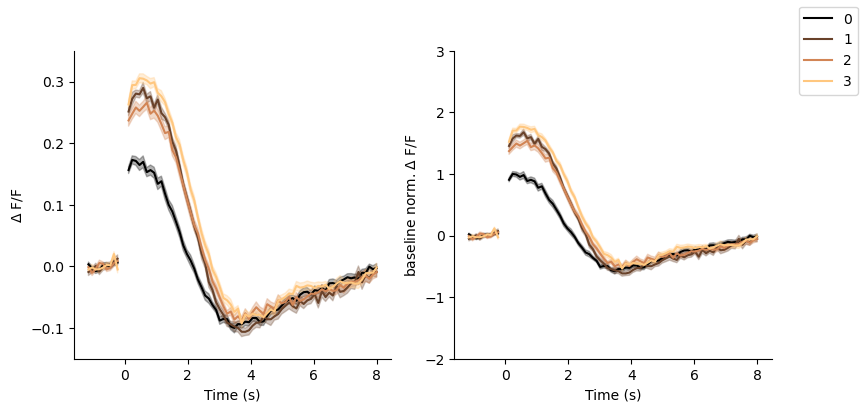

In [10]:
fig, ax = plt.subplots(1,2, figsize=[9,4], sharey=False, sharex=True)

x = np.arange(-10*dt,70*dt-dt/4,dt)
n_scans = len(stim_resp_list)

cmap = plt.cm.copper
for i, srl in enumerate(stim_resp_list):
    mu = np.nanmean(srl -1, axis=0)
    sem = sp.stats.sem(srl-1,axis=0, nan_policy='omit')
    ax[0].plot(x, mu, color=cmap(float(i)/(n_scans-1)))
    ax[0].fill_between(x, mu-sem, mu+sem, color=cmap(float(i)/(n_scans-1)), alpha=.3)
    
    if i ==0:
        baseline = np.nanmax(mu)
    srl_n = (srl-1)/baseline
    # print(srl_n)
    mu_n = np.nanmean(srl_n,axis=0)
    sem_n = sp.stats.sem(srl_n,axis=0, nan_policy='omit')
    ax[1].plot(x,mu_n,color=cmap(float(i)/(n_scans-1)), label=f'{i}')
    ax[1].fill_between(x, mu_n-sem_n, mu_n+sem_n, color=cmap(float(i)/(n_scans-1)), alpha=.3)
    


for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_xlabel('Time (s)')
ax[0].set_ylabel(r"$\Delta$ F/F")
ax[1].set_ylabel(r"baseline norm. $\Delta$ F/F")
ax[0].set_ylim(-.15,.35)
ax[1].set_ylim(-2,3)
fig.legend()
# fig.savefig('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/ex_vivo_pilot/bath_application.pdf')

In [12]:
sessions = ['baseline-001', 'post_sham_washon-002', 'post_sham_washon-003', 'post_sham_washon-004']

d= '13_12_2024'
gd = 'R20A02_R56H10_split_sytjGCaMP7f_CsChrimsontdT'
f= 'fly1'

stim_resp_list_ctrl, dt_ctrl = make_stim_resp_list(gd, d, f, sessions)


sessions = ['baseline-000', 'post_OA_washon-001', 'post_OA_washon-002', 'post_OA_washon-003']
f= 'fly2'

stim_resp_list_oa, dt_oa = make_stim_resp_list(gd, d, f, sessions)

0.115884648
0.11588014799999999
0.11588040000000001
0.11588062199999999
0.11133486
0.11133486
0.111336624
0.111336102


/tmp/ipykernel_1172921/1348758220.py:8: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(srl -1, axis=0)
/tmp/ipykernel_1172921/1348758220.py:17: RuntimeWarning: Mean of empty slice
  mu_n = np.nanmean(srl_n,axis=0)
/tmp/ipykernel_1172921/1348758220.py:29: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(srl -1, axis=0)
/tmp/ipykernel_1172921/1348758220.py:38: RuntimeWarning: Mean of empty slice
  mu_n = np.nanmean(srl_n,axis=0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


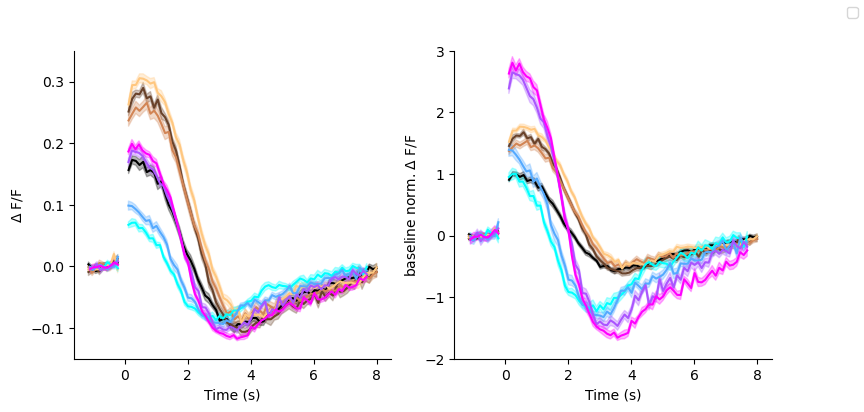

In [10]:
fig, ax = plt.subplots(1,2, figsize=[9,4], sharey=False, sharex=True)

x = np.arange(-10*dt_ctrl,70*dt_ctrl-dt_ctrl/4,dt_ctrl)
n_scans = len(stim_resp_list_ctrl)


for i, srl in enumerate(stim_resp_list_ctrl):
    mu = np.nanmean(srl -1, axis=0)
    sem = sp.stats.sem(srl-1,axis=0, nan_policy='omit')
    ax[0].plot(x, mu, color=plt.cm.copper(float(i)/(n_scans-1)))
    ax[0].fill_between(x, mu-sem, mu+sem, color=plt.cm.copper(float(i)/(n_scans-1)), alpha=.3)
    
    if i ==0:
        baseline = np.nanmax(mu)
    srl_n = (srl-1)/baseline
    # print(srl_n)
    mu_n = np.nanmean(srl_n,axis=0)
    sem_n = sp.stats.sem(srl_n,axis=0, nan_policy='omit')
    ax[1].plot(x,mu_n,color=plt.cm.copper(float(i)/(n_scans-1)))
    ax[1].fill_between(x, mu_n-sem_n, mu_n+sem_n, color=plt.cm.copper(float(i)/(n_scans-1)), alpha=.3)
    


x = np.arange(-10*dt_oa,70*dt_oa-dt_oa/4,dt_oa)
n_scans = len(stim_resp_list_oa)


for i, srl in enumerate(stim_resp_list_oa):
    mu = np.nanmean(srl -1, axis=0)
    sem = sp.stats.sem(srl-1,axis=0, nan_policy='omit')
    ax[0].plot(x, mu, color=plt.cm.cool(float(i)/(n_scans-1)))
    ax[0].fill_between(x, mu-sem, mu+sem, color=plt.cm.cool(float(i)/(n_scans-1)), alpha=.3)
    
    if i ==0:
        baseline = np.nanmax(mu)
    srl_n = (srl-1)/baseline
    # print(srl_n)
    mu_n = np.nanmean(srl_n,axis=0)
    sem_n = sp.stats.sem(srl_n,axis=0, nan_policy='omit')
    ax[1].plot(x,mu_n,color=plt.cm.cool(float(i)/(n_scans-1)))
    ax[1].fill_between(x, mu_n-sem_n, mu_n+sem_n, color=plt.cm.cool(float(i)/(n_scans-1)), alpha=.3)
        


for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_xlabel('Time (s)')
ax[0].set_ylabel(r"$\Delta$ F/F")
ax[1].set_ylabel(r"baseline norm. $\Delta$ F/F")
ax[0].set_ylim(-.15,.35)
ax[1].set_ylim(-2,3)
fig.legend()

0.0 3.814697265625e-06
[0.01239713005964238, 0.03458305112920135, 0.1147792073132805, 0.12222175343274211]
0.0 8.543370000149389e-10


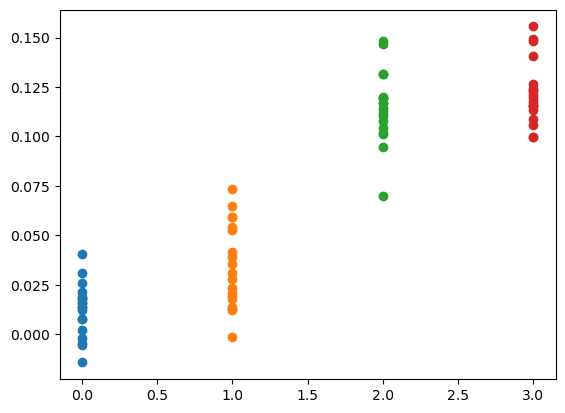

In [13]:
fig, ax = plt.subplots()
for i, sr in enumerate(stim_resp_list):
    r = np.nanmean(sr[:,12:30],axis=-1)-1
    ax.scatter(np.zeros_like(r)+i, r)

t, p = sp.stats.wilcoxon(stim_resp_list[2][:,12:30].mean(axis=-1),stim_resp_list[1][:,12:30].mean(axis=-1))
print(t,p)
print([sr[:,12:30].mean(axis=-1).mean()-1 for sr in stim_resp_list])

f, p = sp.stats.kruskal(stim_resp_list[0][:,12:30].mean(axis=-1),stim_resp_list[1][:,12:30].mean(axis=-1),stim_resp_list[2][:,12:30].mean(axis=-1))
print(t,p)

In [7]:
# 